# Simple Rules

This notebook shows how simple trading rules work with each trading environment, these are mainly taken from [Advanced Futures Trading Strategies](https://www.amazon.co.uk/Advanced-Futures-Trading-Strategies-strategies-ebook/dp/B0BCKP2ZK9). The rules are as follows:
- **Hold**: Take a long position and hold it for the entire period.
- **Exponentially Weighted Moving Average Crossover** (EWMAC): Buy when the short moving average crosses above the long moving average, sell when the short moving average crosses below the long moving average.
- **Breakout**: Buy when the price crosses above the highest high of the last n periods, sell when the price crosses below the lowest low of the last n periods.

In [1]:
import gymnasium as gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Tuple

import deeptrade.env
from deeptrade.env import HoldAgent, EWMACAgent, BreakoutAgent
import deeptrade.util.finance as futils

COLOURS = [[0, 18, 25], [0, 95, 115], [10, 147, 150], [148, 210, 189], [233, 216, 166], [238, 155, 0], [202, 103, 2], [187, 62, 3], [174, 32, 18], [155, 34, 38]]
COLOURS = [[value/255 for value in rgb] for rgb in COLOURS]

## Hold

Initially setup and environment and then plot the Hold strategy with the traded performance. The performance of the hold strategy is maximized with a positive price movement and minimal vol. The expected return is simply the drift of the price times the $size$ of the position. Defining the asset price $S_{t}$ at time $t$ as a discrete time process with drift $\mu$ and var $\sigma$:
$$
    S_{t+1} = S_{t} + \mathcal{N}(\mu, \sigma^{2}) ,
$$
the expected return of the buy and hold strategy is simply: $\sum_{t=0}^{T} size \times \mu$. This discrete time process is equivalent to the continuous time process:
$$
    dS_{t} = \mu dt + \sigma dW_{t},  
$$
where $dW_{t}$ is a Wiener process.

In [2]:
seed = 0
pos_size = 10.0  # How large of a position to hold in the asset.
drift = 0.0
vol = 0.01
n_days = 1000
price_gen_info = {
    'starting_price': 100.0,
    'drift': drift,
    'vol': vol,
    'n_days': n_days,
}
env = gym.make('SingleInstrument-v0', seed=seed, price_gen_info=price_gen_info)
agent = HoldAgent(env, pos_size=pos_size)

In [3]:
# Rollout the strategy

terminated = False
truncated = False
observations = []
actions = []
times = []
obs, _ = env.reset(seed=seed)
while (not terminated) and (not truncated):
    action = agent.act(obs)
    obs, reward, terminated, truncated, _ = env.step(action)
    observations.append(obs)
    actions.append(action)
    times.append(env.unwrapped.time)
    
observations = np.array(observations)
actions = np.array(actions)

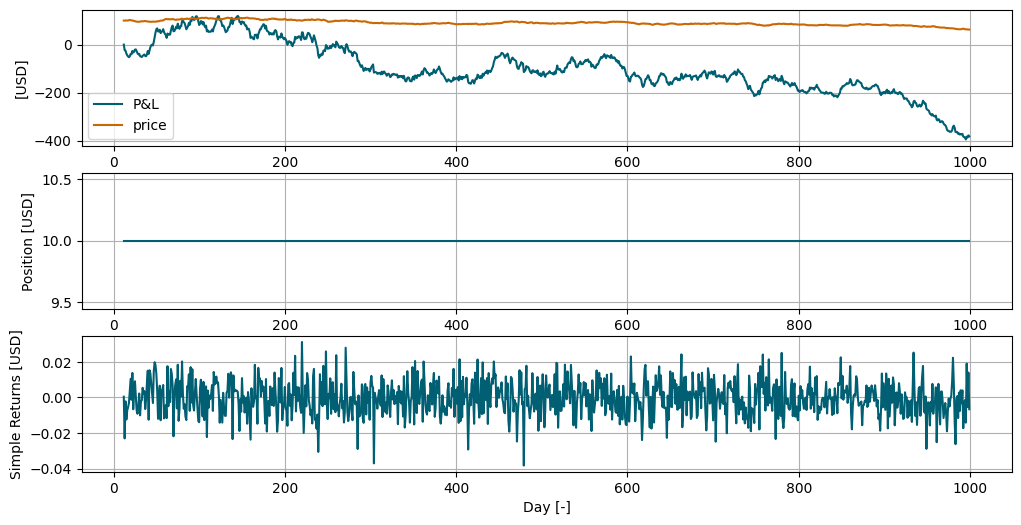

In [4]:

fig, ax = plt.subplots(3, 1, figsize=(12, 6))
data = {
    "pandl": observations[:, -1] - observations[0, -1],  # subtract starting capital
    "price": env.unwrapped.price_data[:len(times)],        
    "position": observations[:, -2],
    "returns": observations[:, -3]
}
ax[0].plot(times, data["pandl"], color=COLOURS[1], label="P&L")
ax[0].plot(times, data["price"], color=COLOURS[6], label="price")
ax[0].set_ylabel("[USD]")
ax[0].legend()
ax[0].grid()
ax[1].plot(times, data["position"], color=COLOURS[1])
ax[1].set_ylabel("Position [USD]")
ax[1].grid()
ax[2].plot(times, data["returns"], color=COLOURS[1])
ax[2].set_xlabel("Day [-]")
ax[2].set_ylabel("Simple Returns [USD]")
ax[2].grid()
# ax.plot(times, position)
# ax.plot(times, returns)
# ax.plot(times, env.unwrapped.price_data[:len(times)])
fig.show()

In [5]:
def get_stats(trial_dataframe, key) -> List[np.ndarray]:
    """Get average and var for key in dataframe"""
    
    max_length = max(len(arr) for arr in trial_dataframe[key].values)
    padded_key = [np.pad(arr, (0, max_length - len(arr)), 'constant') for arr in trial_dataframe[key].values]
    return np.mean(np.vstack(padded_key), axis=0), np.std(np.vstack(padded_key), axis=0)

In [6]:
# Simulate n trials
n_seeds = 1000
trial_data = {}

for ids in range(n_seeds):
    seed = ids
    env = gym.make('SingleInstrument-v0', seed=seed, price_gen_info=price_gen_info)
    obs, _ = env.reset(seed=seed)
    agent = HoldAgent(env, pos_size=pos_size)
    terminated, truncated = False, False
    observations = []
    actions = []
    times = []
    obs, _ = env.reset(seed=seed)
    while (not terminated) and (not truncated):
        action = agent.act(obs)
        obs, reward, terminated, truncated, _ = env.step(action)
        observations.append(obs)
        actions.append(action)
        times.append(env.unwrapped.time)
        
    observations = np.array(observations)
    actions = np.array(actions)
    data = {
        "pandl": observations[:, -1] - observations[0, -1],  # subtract starting capital
        "price": env.unwrapped.price_data[:len(times)],        
        "position": observations[:, -2],
        "returns": observations[:, -3]
    }
    trial_data[ids] = data

In [7]:
hold_dataframe = pd.DataFrame(trial_data).transpose()
avg_hold_pandl, var_hold_pandl = get_stats(hold_dataframe, "pandl")
avg_hold_price, var_hold_price = get_stats(hold_dataframe, "price")

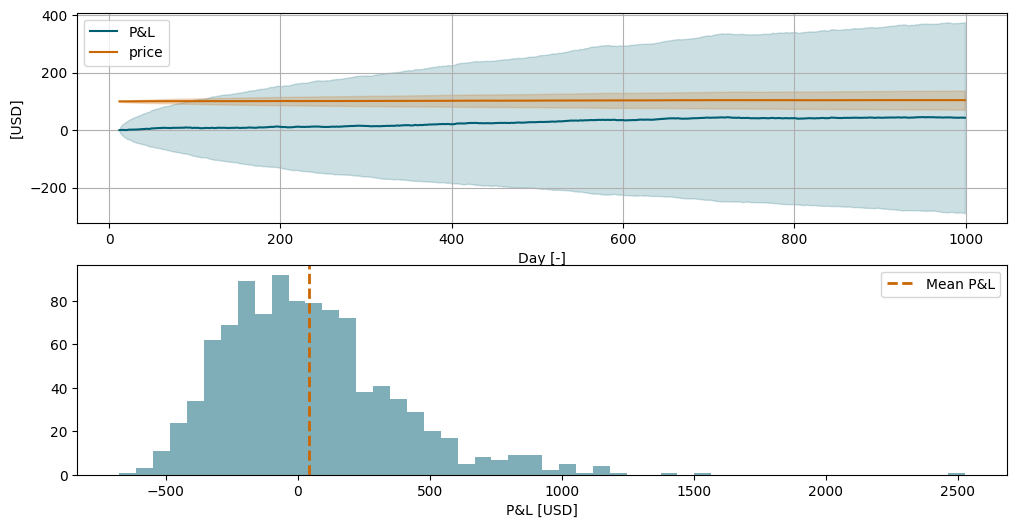

In [8]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6))

ax[0].plot(times, avg_hold_pandl, color=COLOURS[1], label="P&L")
ax[0].fill_between(times, avg_hold_pandl - var_hold_pandl, avg_hold_pandl + var_hold_pandl, color=COLOURS[1], alpha=0.2)
ax[0].plot(times, avg_hold_price, color=COLOURS[6], label="price")
ax[0].fill_between(times, avg_hold_price - var_hold_price, avg_hold_price + var_hold_price, color=COLOURS[6], alpha=0.2)
ax[0].set_ylabel("[USD]")
ax[0].set_xlabel("Day [-]")
ax[0].legend()
ax[0].grid()

ax[1].hist(hold_dataframe["pandl"].apply(lambda x: x[-1]), bins=50, color=COLOURS[1], alpha=0.5)
ax[1].axvline(avg_hold_pandl[-1], color=COLOURS[6], linestyle='dashed', linewidth=2, label='Mean P&L')
ax[1].legend()
ax[1].set_xlabel("P&L [USD]")

fig.show()

The EWMAC strategy is based on the crossover of two exponentially weighted moving averages (EWMA) of different lengths. The strategy generates buy and sell signals based on the relationship between the short-term and long-term EWMAs. Specifically:

- **Buy Signal**: When the short-term EWMA crosses above the long-term EWMA.
- **Sell Signal**: When the short-term EWMA crosses below the long-term EWMA.

The EWMAC strategy aims to capture trends by entering long positions during upward trends and exiting or entering short positions during downward trends.

Defining the asset price, $S_{t}$, at time $t$ as a discrete time process with drift $\mu$ and var $\sigma^{2}$:
$$
    S_{t+1} = S_{t} + \mathcal{N}(\mu, \sigma^{2}),
$$
the EWMAC strategy uses two EWMAs:
$$
    \text{EWMA}_{\text{short}}(t) = \alpha_{\text{short}} S_{t} + (1 - \alpha_{\text{short}}) \text{EWMA}_{\text{short}}(t-1)
$$
$$
    \text{EWMA}_{\text{long}}(t) = \alpha_{\text{long}} S_{t} + (1 - \alpha_{\text{long}}) \text{EWMA}_{\text{long}}(t-1)
$$
where $\alpha_{\text{short}}$ and $\alpha_{\text{long}}$ are the smoothing factors for the short-term and long-term EWMAs, respectively.

The strategy generates signals based on the difference between these two EWMAs:
$$
    \text{Signal}(t) = \text{EWMA}_{\text{short}}(t) - \text{EWMA}_{\text{long}}(t)
$$

A positive signal indicates a buy, while a negative signal indicates a sell. The performance of the EWMAC strategy is influenced by the choice of the smoothing factors and the ability to adapt to changing market conditions.

In [9]:
seed = 0
pos_size = 10.0  # How large of a position to hold in the asset.
drift = 0.0
vol = 0.01
n_days = 1000
price_gen_info = {
    'starting_price': 100.0,
    'drift': drift,
    'vol': vol,
    'n_days': n_days,
}
env = gym.make('SingleInstrument-v0', seed=seed, price_gen_info=price_gen_info)

fast_period = 40
slow_period = 80
agent = EWMACAgent(env, fast_period=fast_period, slow_period=slow_period)

In [10]:
terminated = False
truncated = False
observations = []
actions = []
times = []
obs, _ = env.reset(seed=seed)
while (not terminated) and (not truncated):
    action = agent.act(obs)
    obs, reward, terminated, truncated, _ = env.step(action)
    observations.append(obs)
    actions.append(action)
    times.append(env.unwrapped.time)
    
observations = np.array(observations)
actions = np.array(actions)

data = {
    "pandl": observations[:, -1] - observations[0, -1],  # subtract starting capital
    "price": env.unwrapped.price_data[:len(times)],        
    "position": observations[:, -2],
    "returns": observations[:, -3]
}

/home/quessy/.conda/envs/deeptrade-env/lib/python3.10/site-packages/deeptrade/env/agents/ewmac.py:53: RuntimeWarning: Mean of empty slice.
  fast = np.array(price_data[time-self.fast_period:time]).mean()
/home/quessy/.conda/envs/deeptrade-env/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/quessy/.conda/envs/deeptrade-env/lib/python3.10/site-packages/deeptrade/env/agents/ewmac.py:54: RuntimeWarning: Mean of empty slice.
  slow = np.array(price_data[time-self.slow_period:time]).mean()


/home/quessy/.conda/envs/deeptrade-env/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


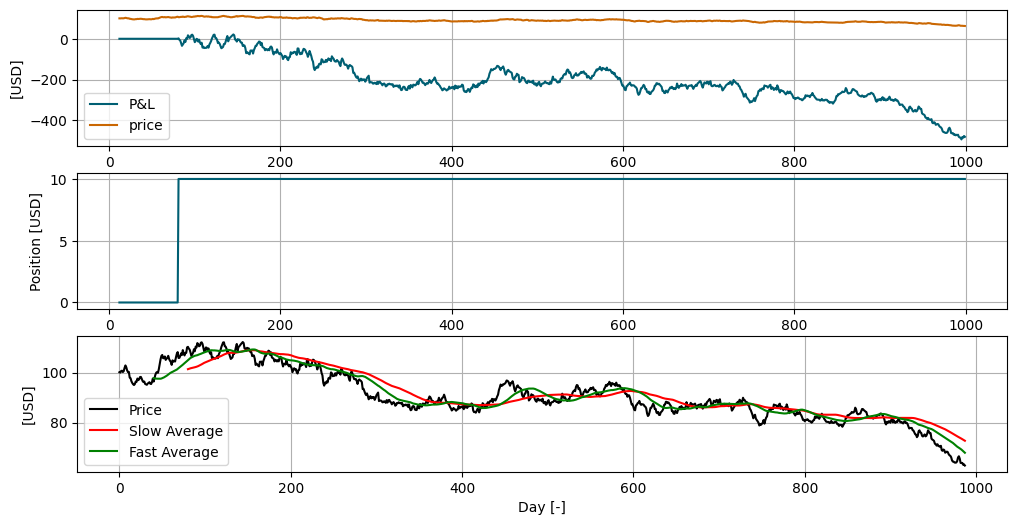

In [11]:
# Analyzing EWMAC closer
slow_averages = []
fast_averages = []

for time in range(len(data["price"])):
    slow_averages.append(np.mean(data["price"][time-slow_period:time]))
    fast_averages.append(np.mean(data["price"][time-fast_period:time]))
    
fig, ax = plt.subplots(3, 1, figsize=(12, 6))
ax[0].plot(times, data["pandl"], color=COLOURS[1], label="P&L")
ax[0].plot(times, data["price"], color=COLOURS[6], label="price")
ax[0].set_ylabel("[USD]")
ax[0].legend()
ax[0].grid()
ax[1].plot(times, data["position"], color=COLOURS[1])
ax[1].set_ylabel("Position [USD]")
ax[1].grid()
ax[2].plot(data["price"], label="Price", color='black')
ax[2].plot(slow_averages, label="Slow Average", color='red')
ax[2].plot(fast_averages, label="Fast Average", color='green')
ax[2].grid()
ax[2].set_ylabel("[USD]")
ax[2].set_xlabel("Day [-]")
ax[2].legend()
fig.show()

In [12]:
# Simulate n trials
n_seeds = 1000
trial_data = {}

for ids in range(n_seeds):
    seed = ids
    env = gym.make('SingleInstrument-v0', seed=seed, price_gen_info=price_gen_info)
    obs, _ = env.reset(seed=seed)
    agent = EWMACAgent(env, fast_period=fast_period, slow_period=slow_period)
    terminated, truncated = False, False
    observations = []
    actions = []
    times = []
    obs, _ = env.reset(seed=seed)
    while (not terminated) and (not truncated):
        action = agent.act(obs)
        obs, reward, terminated, truncated, _ = env.step(action)
        observations.append(obs)
        actions.append(action)
        times.append(env.unwrapped.time)
        
    observations = np.array(observations)
    actions = np.array(actions)
    data = {
        "pandl": observations[:, -1] - observations[0, -1],  # subtract starting capital
        "price": env.unwrapped.price_data[:len(times)],        
        "position": observations[:, -2],
        "returns": observations[:, -3]
    }
    trial_data[ids] = data

In [13]:
ewmac_dataframe = pd.DataFrame(trial_data).transpose()
avg_ewmac_pandl, var_ewmac_pandl = get_stats(ewmac_dataframe, "pandl")
avg_ewmac_price, var_ewmac_pandl = get_stats(ewmac_dataframe, "price")

Text(0.5, 0, 'P&L [USD]')

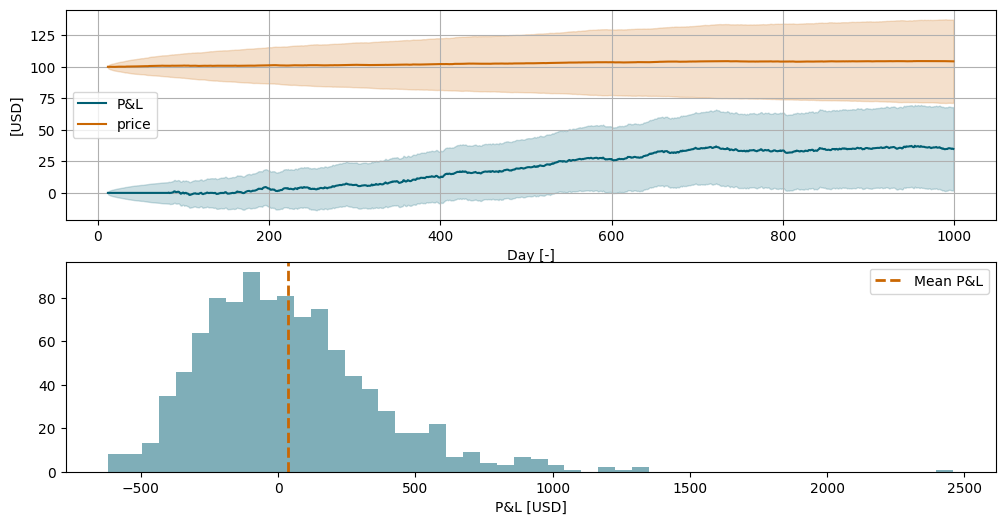

In [14]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6))

ax[0].plot(times, avg_ewmac_pandl, color=COLOURS[1], label="P&L")
ax[0].fill_between(times, avg_ewmac_pandl - var_ewmac_pandl, avg_ewmac_pandl + var_ewmac_pandl, color=COLOURS[1], alpha=0.2)
ax[0].plot(times, avg_ewmac_price, color=COLOURS[6], label="price")
ax[0].fill_between(times, avg_ewmac_price - var_ewmac_pandl, avg_ewmac_price + var_ewmac_pandl, color=COLOURS[6], alpha=0.2)
ax[0].set_ylabel("[USD]")
ax[0].set_xlabel("Day [-]")
ax[0].legend()
ax[0].grid()

ax[1].hist(ewmac_dataframe["pandl"].apply(lambda x: x[-1]), bins=50, color=COLOURS[1], alpha=0.5)
ax[1].axvline(avg_ewmac_pandl[-1], color=COLOURS[6], linestyle='dashed', linewidth=2, label='Mean P&L')
ax[1].legend()
ax[1].set_xlabel("P&L [USD]")

The breakout strategy is based on the concept of support and resistance levels. The strategy generates buy and sell signals based on the price crossing above or below the highest high or lowest low of the last n periods, respectively. Specifically:


In [15]:
seed = 0
pos_size = 10.0  # How large of a position to hold in the asset.
drift = 0.0
vol = 0.01
n_days = 1000
lookback_period = 40
price_gen_info = {
    'starting_price': 100.0,
    'drift': drift,
    'vol': vol,
    'n_days': n_days,
}
env = gym.make('SingleInstrument-v0', seed=seed, price_gen_info=price_gen_info)
agent = BreakoutAgent(env, lookback_period=lookback_period)

In [16]:
terminated = False
truncated = False
observations = []
actions = []
times = []
obs, _ = env.reset(seed=seed)
while (not terminated) and (not truncated):
    action = agent.act(obs)
    # print(f"action: {action.item()}")
    obs, reward, terminated, truncated, _ = env.step(action)
    observations.append(obs)
    actions.append(action)
    times.append(env.unwrapped.time)
    
observations = np.array(observations)
actions = np.array(actions)

data = {
    "pandl": observations[:, -1] - observations[0, -1],  # subtract starting capital
    "price": env.unwrapped.price_data[:len(times)],        
    "position": observations[:, -2],
    "returns": observations[:, -3]
}

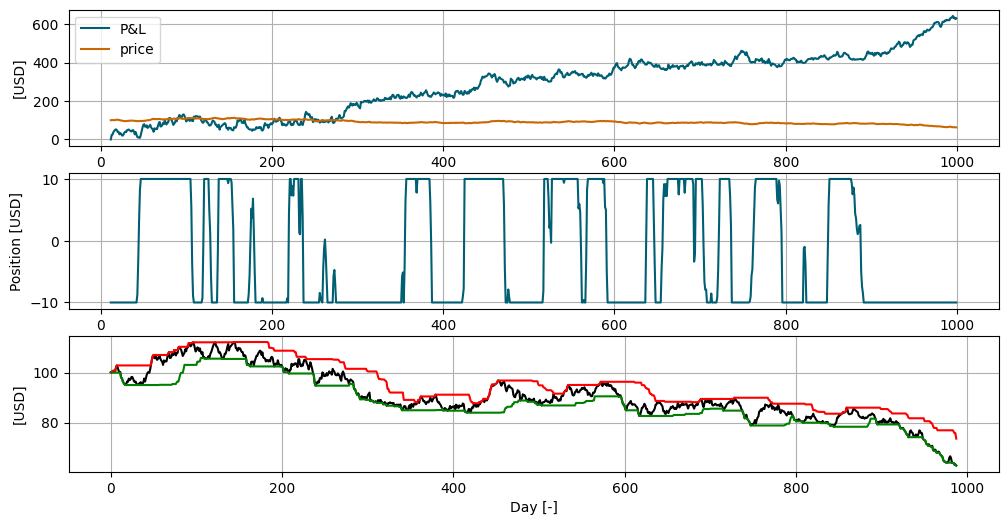

In [17]:
def calculate_rolling_extremes(time, prices: np.ndarray):
        
        window = prices[max(0, time - lookback_period + 1):time + 1]
        roll_max = np.max(window)
        roll_min = np.min(window)

        return roll_max, roll_min

roll_maxs, roll_mins = [], []

for time in range(len(data["price"])):
        roll_max, roll_min = calculate_rolling_extremes(time, data["price"])
        roll_maxs.append(roll_max)
        roll_mins.append(roll_min)

fig, ax = plt.subplots(3, 1, figsize=(12, 6))
ax[0].plot(times, data["pandl"], color=COLOURS[1], label="P&L")
ax[0].plot(times, data["price"], color=COLOURS[6], label="price")
ax[0].set_ylabel("[USD]")
ax[0].legend()
ax[0].grid()
ax[1].plot(times, data["position"], color=COLOURS[1])
ax[1].set_ylabel("Position [USD]")
ax[1].grid()
ax[2].plot(data["price"], label="Price", color='black')
ax[2].plot(roll_maxs, label="Rolling Max", color='red')
ax[2].plot(roll_mins, label="Rolling Min", color='green')
ax[2].set_ylabel("[USD]")
ax[2].set_xlabel("Day [-]")
ax[2].grid()
fig.show()

In [18]:
# Simulate n trials
n_seeds = 1000
trial_data = {}

for ids in range(n_seeds):
    seed = ids
    env = gym.make('SingleInstrument-v0', seed=seed, price_gen_info=price_gen_info)
    obs, _ = env.reset(seed=seed)
    agent = BreakoutAgent(env, lookback_period=lookback_period)
    terminated, truncated = False, False
    observations = []
    actions = []
    times = []
    obs, _ = env.reset(seed=seed)
    while (not terminated) and (not truncated):
        action = agent.act(obs)
        obs, reward, terminated, truncated, _ = env.step(action)
        observations.append(obs)
        actions.append(action)
        times.append(env.unwrapped.time)
        
    observations = np.array(observations)
    actions = np.array(actions)
    data = {
        "pandl": observations[:, -1] - observations[0, -1],  # subtract starting capital
        "price": env.unwrapped.price_data[:len(times)],        
        "position": observations[:, -2],
        "returns": observations[:, -3]
    }
    trial_data[ids] = data

breakout_dataframe = pd.DataFrame(trial_data).transpose()

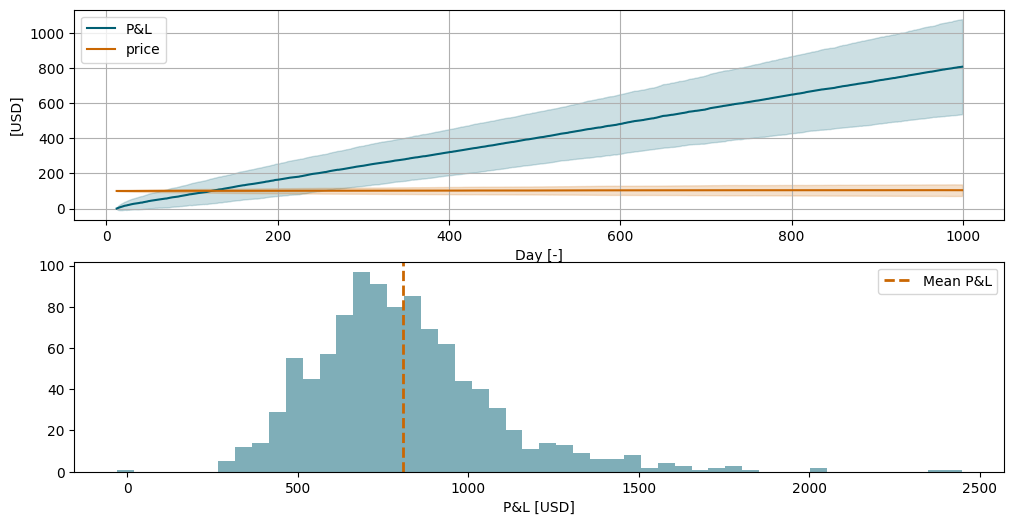

In [19]:
avg_breakout_pandl, var_breakout_pandl = get_stats(breakout_dataframe, "pandl")
avg_breakout_price, var_breakout_price = get_stats(breakout_dataframe, "price")

fig, ax = plt.subplots(2, 1, figsize=(12, 6))

ax[0].plot(times, avg_breakout_pandl, color=COLOURS[1], label="P&L")
ax[0].fill_between(times, avg_breakout_pandl - var_breakout_pandl, avg_breakout_pandl + var_breakout_pandl, color=COLOURS[1], alpha=0.2)
ax[0].plot(times, avg_breakout_price, color=COLOURS[6], label="price")
ax[0].fill_between(times, avg_breakout_price - var_breakout_price, avg_breakout_price + var_breakout_price, color=COLOURS[6], alpha=0.2)
ax[0].set_ylabel("[USD]")
ax[0].set_xlabel("Day [-]")
ax[0].legend()
ax[0].grid()

ax[1].hist(breakout_dataframe["pandl"].apply(lambda x: x[-1]), bins=50, color=COLOURS[1], alpha=0.5)
ax[1].axvline(avg_breakout_pandl[-1], color=COLOURS[6], linestyle='dashed', linewidth=2, label='Mean P&L')
ax[1].legend()
ax[1].set_xlabel("P&L [USD]")

fig.show()

## Comparing the total return of each strategy

Hold Sharpe: 1.889, EWMAC Sharpe: 1.376, Breakout Sharpe: 1.771
Hold Sortino: 0.028, EWMAC Sortino: 0.020, Breakout Sortino: 0.644


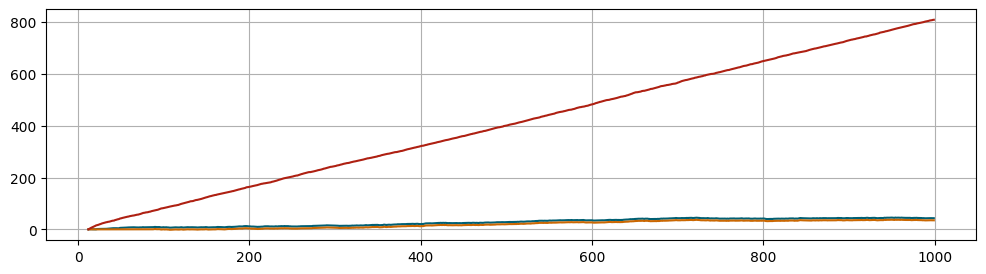

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(12, 3))

ax.plot(times, avg_hold_pandl, color=COLOURS[1], label="Hold")
ax.plot(times, avg_ewmac_pandl, color=COLOURS[6], label="EWMAC")
ax.plot(times, avg_breakout_pandl, color=COLOURS[8], label="Breakout")
ax.grid()
fig.show()

import deeptrade.util.finance as futils
hold_sharpe = futils.calculate_sharpe_ratio(avg_hold_pandl)
ewmac_sharpe = futils.calculate_sharpe_ratio(avg_ewmac_pandl)
breakout_sharpe = futils.calculate_sharpe_ratio(avg_breakout_pandl)
print(f"Hold Sharpe: {hold_sharpe:.3f}, EWMAC Sharpe: {ewmac_sharpe:.3f}, Breakout Sharpe: {breakout_sharpe:.3f}")

hold_sortino = futils.calculate_sortino_ratio(avg_hold_pandl, target_return=1000.0)
ewmac_sortino = futils.calculate_sortino_ratio(avg_ewmac_pandl, target_return=1000.0)
breakout_sortino = futils.calculate_sortino_ratio(avg_breakout_pandl, target_return=1000.0)

print(f"Hold Sortino: {hold_sortino:.3f}, EWMAC Sortino: {ewmac_sortino:.3f}, Breakout Sortino: {breakout_sortino:.3f}")